In [1]:
from lightgbm import LGBMRegressor

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    mean_squared_log_error

from catboost import CatBoostRegressor
import shap

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings("ignore")

RAND = 10
N_FOLDS = 3

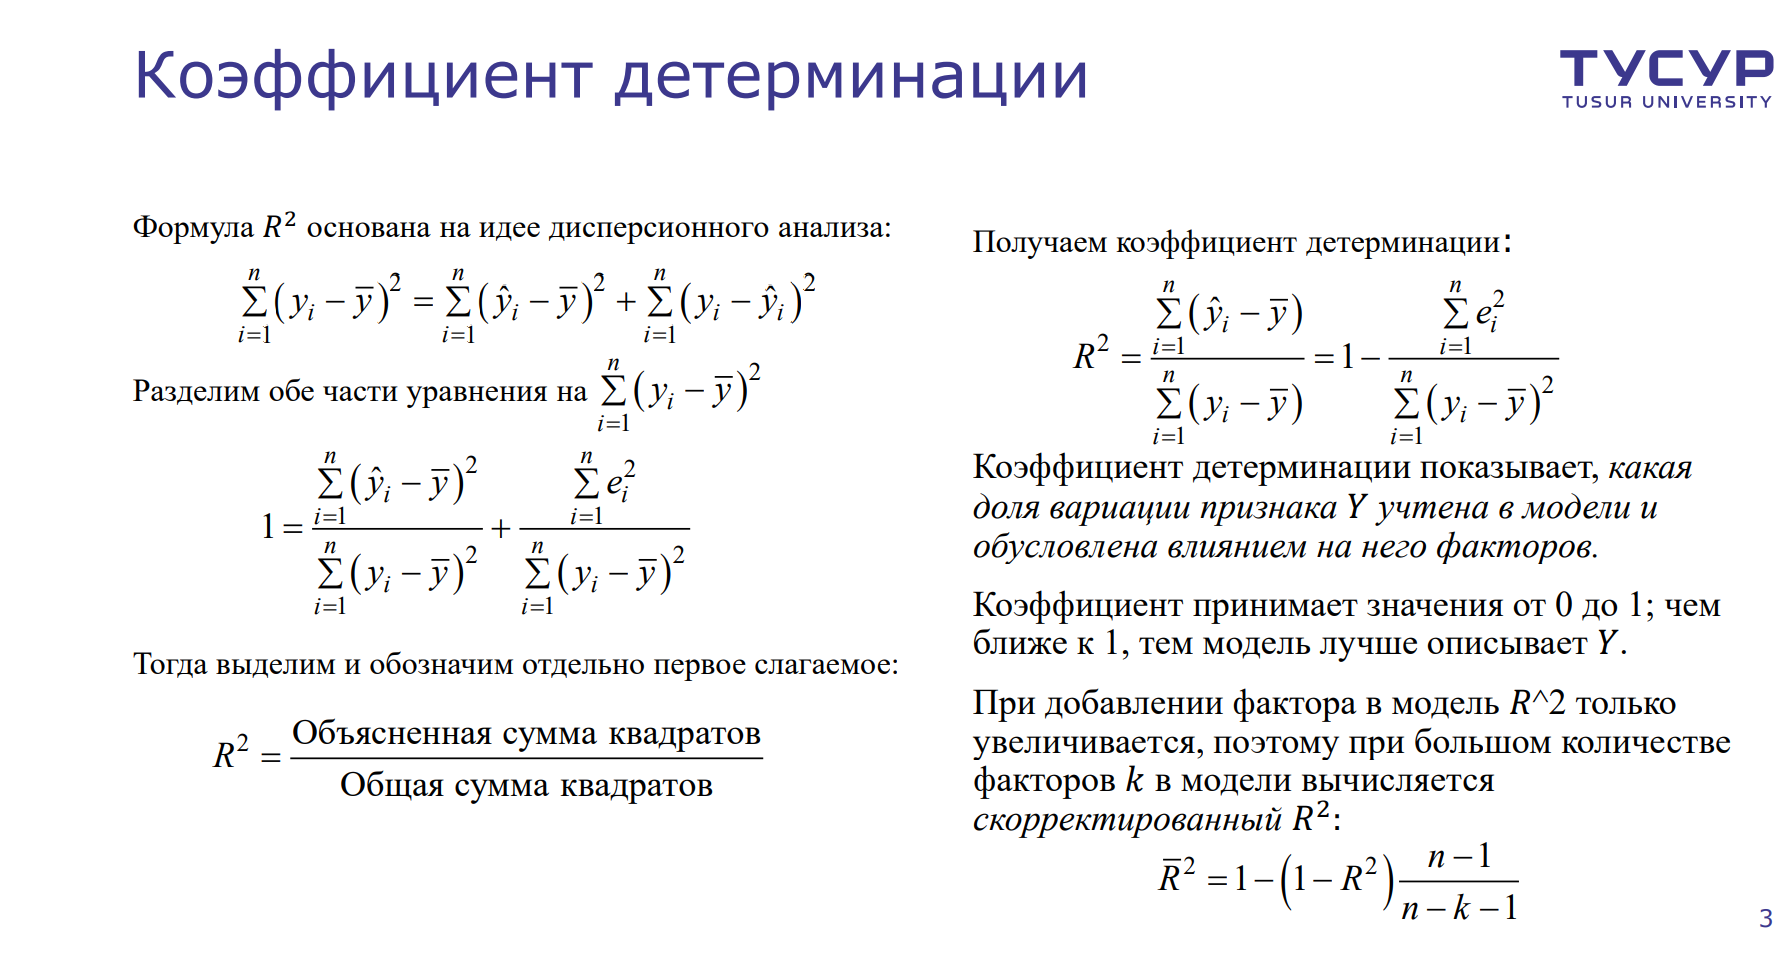

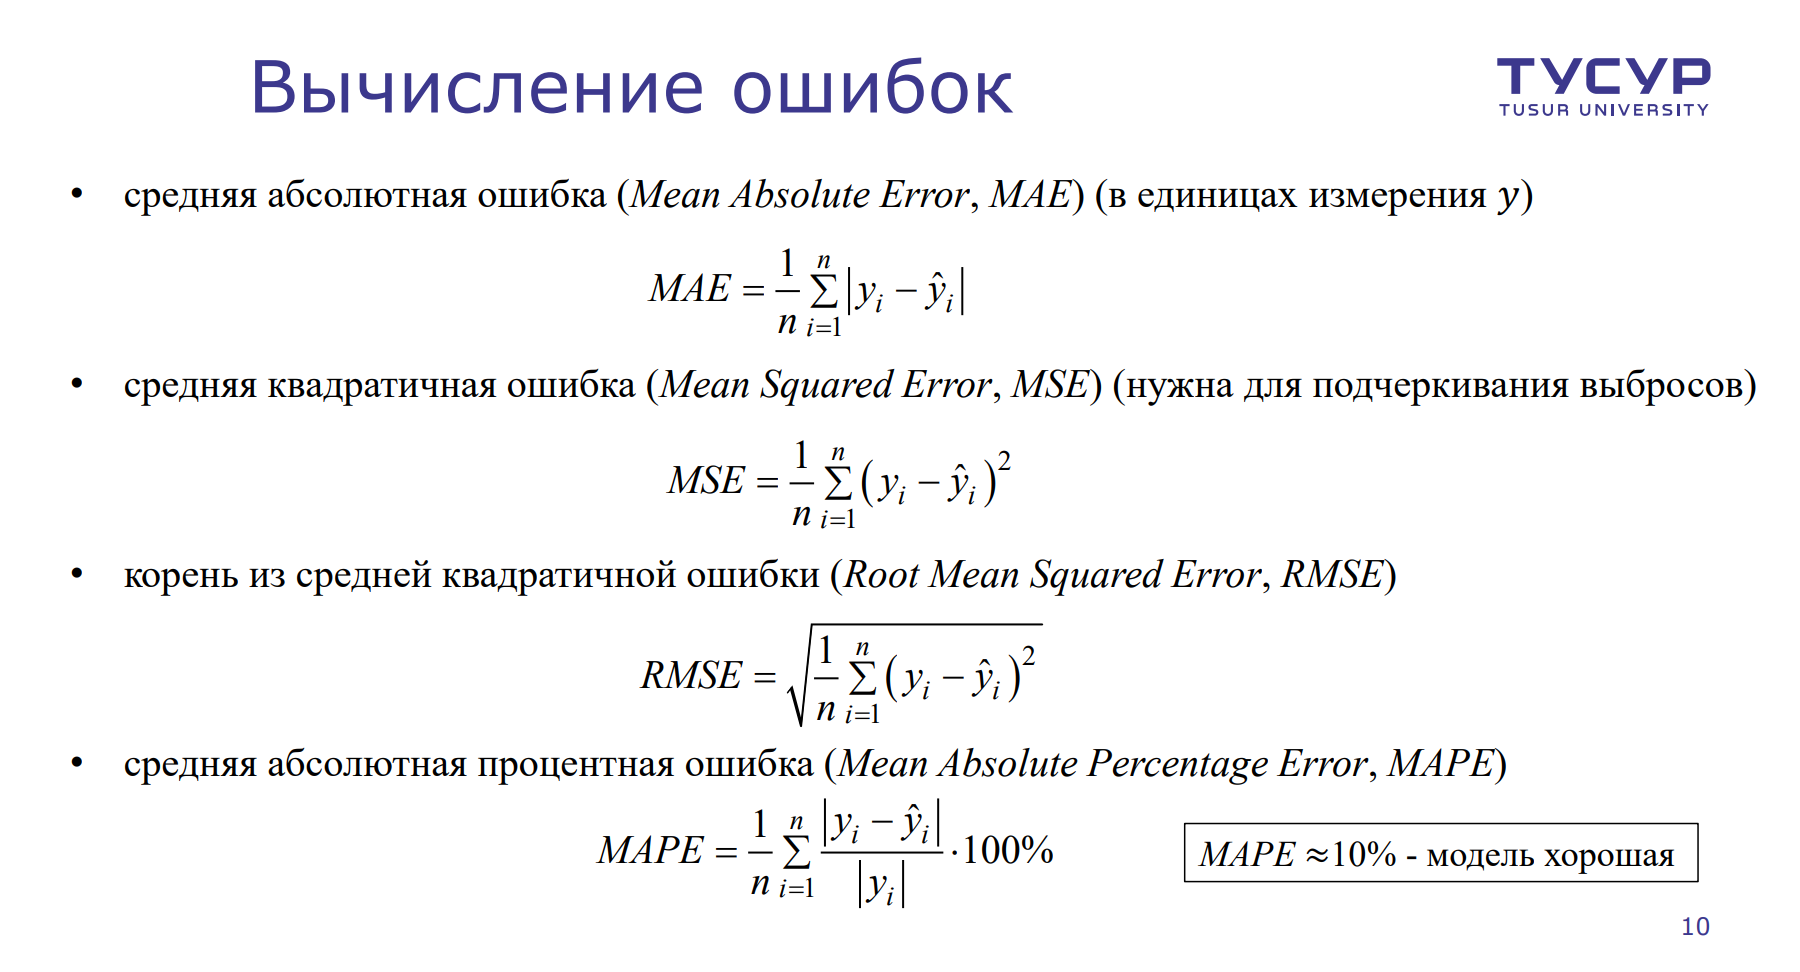

применение функции к каждой строк или столбцу
axis = 0 или «индекс»: применить функцию к каждому столбцу.
axis = 1 или «столбцы»: применить функцию к каждой строке.

In [2]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    #Он показывает, какая доля дисперсии результативного признака объясняется влиянием независимых переменных. 
  
    N_objects = len(y_true) #count objects
    N_features = X_test.shape[1] #count feauters
    r2 = r2_score(y_true, y_pred) # (coefficient of determination) regression score function.
    #sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error""" #~10 % good model
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)

    return df_metrics


def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

In [3]:
df = pd.read_csv('data_cars\clean_full_dataset.csv')

In [4]:
df = df[df.flg_new_auto == 0] #only no new car

In [5]:
df[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,flg_new_auto,body_type
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,3.2,204.0,дизель,автомат,задний,350.0,0,Седан
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23,2.8,193.0,бензин,автомат,задний,360.0,0,Седан
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,31,3.0,220.0,бензин,автомат,задний,352.0,0,Седан
3,1,Mercedes-Benz,C-Class,2011,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,11,1.8,156.0,бензин,автомат,задний,134.0,0,Седан


# Modeling

In [6]:
cols_drop = [
    'brand', 'num', 'year', 'median_salary', 'Region_en', 'NAME_1',
    'flg_more_avg_salary', 'flg_new_auto'
]
df = df.drop(cols_drop, axis=1)

cols_cat = df.select_dtypes('object').columns
df[cols_cat] = df[cols_cat].astype('category')
#astype() Method:DataFrame.astype() method is used to convert pandas object to a given datatype. 
#The astype() function can also convert any acceptable existing column to a categorical type.
#Тип данных категории (category data type) в pandas - это гибридный тип. 
#Во многих случаях он выглядит и ведет себя как строка, но внутренне представлен массивом целых чисел.

In [7]:
df[:4]

,model,price,region,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,body_type
0,E-Class,830000,Республика Адыгея,16,3.2,204.0,дизель,автомат,задний,350.0,Седан
1,E-Class,280000,Республика Адыгея,23,2.8,193.0,бензин,автомат,задний,360.0,Седан
2,E-Class,200000,Республика Адыгея,31,3.0,220.0,бензин,автомат,задний,352.0,Седан
3,C-Class,900000,Республика Адыгея,11,1.8,156.0,бензин,автомат,задний,134.0,Седан


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24926 entries, 0 to 26082
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   model          24926 non-null  category
 1   price          24926 non-null  int64   
 2   region         24926 non-null  category
 3   age            24926 non-null  int64   
 4   liters         24926 non-null  float64 
 5   horse_power    24926 non-null  float64 
 6   type_engine    24926 non-null  category
 7   transmission   24926 non-null  category
 8   machine_drive  24926 non-null  category
 9   mileage        24926 non-null  float64 
 10  body_type      24926 non-null  category
dtypes: category(6), float64(3), int64(2)
memory usage: 1.3 MB


In [9]:
df.shape

(24926, 11)

In [10]:
df.head()

,model,price,region,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,body_type
0,E-Class,830000,Республика Адыгея,16,3.2,204.0,дизель,автомат,задний,350.0,Седан
1,E-Class,280000,Республика Адыгея,23,2.8,193.0,бензин,автомат,задний,360.0,Седан
2,E-Class,200000,Республика Адыгея,31,3.0,220.0,бензин,автомат,задний,352.0,Седан
3,C-Class,900000,Республика Адыгея,11,1.8,156.0,бензин,автомат,задний,134.0,Седан
4,A-Class,250000,Республика Адыгея,22,1.6,102.0,бензин,механика,передний,228.0,Хэтчбэк


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24926 entries, 0 to 26082
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   model          24926 non-null  category
 1   price          24926 non-null  int64   
 2   region         24926 non-null  category
 3   age            24926 non-null  int64   
 4   liters         24926 non-null  float64 
 5   horse_power    24926 non-null  float64 
 6   type_engine    24926 non-null  category
 7   transmission   24926 non-null  category
 8   machine_drive  24926 non-null  category
 9   mileage        24926 non-null  float64 
 10  body_type      24926 non-null  category
dtypes: category(6), float64(3), int64(2)
memory usage: 1.3 MB


In [12]:
#df = pd.concat([df, region_cols, model_cols, body_type_cols]. axis = 1)
#df.head()

X = df.drop('price', axis = 1)
y = df['price']
#Метод train_test_split() используется для разделения наших данных на обучающие и тестовые наборы.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True, #shuffle: логический объект , по умолчанию True. Следует ли перетасовывать данные перед разделением.
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18694 entries, 13173 to 18223
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   model          18694 non-null  category
 1   region         18694 non-null  category
 2   age            18694 non-null  int64   
 3   liters         18694 non-null  float64 
 4   horse_power    18694 non-null  float64 
 5   type_engine    18694 non-null  category
 6   transmission   18694 non-null  category
 7   machine_drive  18694 non-null  category
 8   mileage        18694 non-null  float64 
 9   body_type      18694 non-null  category
dtypes: category(6), float64(3), int64(1)
memory usage: 844.6 KB


## Baseline

In [14]:
from sklearn.compose import ColumnTransformer


transformers_list = [
    ('encode', OneHotEncoder(dtype='int', drop='first'), [
        'region', 'model', 'region', 'type_engine', 'transmission',
        'machine_drive', 'body_type'
    ]),
    ('scale', StandardScaler(),
     ['age', 'liters', 'horse_power', 'mileage'])
]

column_transformer = ColumnTransformer(transformers_list)

In [15]:
pipe = Pipeline([('columnTransformer', column_transformer),
                 ('lr', LinearRegression())])
pipe.fit(X_train, y_train) #fit - получает данные и строит модель на основе заданной (регрессия, деревья и тд)

y_pred = pipe.predict(X_test)
#Конвейеры машинного обучения (Pipeline) — это итеративные циклы, которые повторяют каждый шаг несколько раз. 

In [16]:
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,799213.130202,1.724636e+12,1.313254e+06,None,0.74152,17.192612,74.736774,34.202451


In [17]:
pipe[:4]

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(transformers=[('encode',
                                                  OneHotEncoder(drop='first',
                                                                dtype='int'),
                                                  ['region', 'model', 'region',
                                                   'type_engine',
                                                   'transmission',
                                                   'machine_drive',
                                                   'body_type']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'liters',
                                                   'horse_power',
                                                   'mileage'])])),
                ('lr', LinearRegression())])

In [18]:
check_overfitting(pipe,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 807729.558
mean_absolute_error test: 799213.130
delta = 1.1 %


ошибка на 800 тыс не приемлема в цене на авто=) зато переобучение всего 1 %)  MAE  не зависит от разброса данных

## LGBMRegressor

на бустинги лучше брать датасет от 50 тыс.

In [19]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')
lgb.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = lgb.predict(X_test)

In [20]:
metrics = metrics.append(get_metrics(y_test, y_pred, X_test, 'LGBMRegressor'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,799213.130202,1.724636e+12,1.313254e+06,NaN,0.741520,17.192612,74.736774,34.202451
0,LGBMRegressor,288587.249104,3.886503e+11,6.234182e+05,0.242411,0.941751,-3.810651,16.634980,12.350136


In [21]:
check_overfitting(lgb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 265661.313
mean_absolute_error test: 288587.249
delta = 8.6 %


## Cat boost regrassion

In [22]:
from catboost import Pool

In [23]:
cat_features = X_val.select_dtypes('category').columns.tolist()

cb = CatBoostRegressor(random_seed=RAND,
                       loss_function='MAE',
                       eval_metric='MAE',
                       cat_features=cat_features,
                       allow_writing_files=False)

eval_set = [(X_val, y_val)]

cb.fit(X_train_,
       y_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)

y_pred_cb = cb.predict(X_test)

In [24]:
metrics = metrics.append(get_metrics(y_test, y_pred_cb, X_test, 'CatBoostRegressor'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,799213.130202,1.724636e+12,1.313254e+06,NaN,0.741520,17.192612,74.736774,34.202451
0,LGBMRegressor,288587.249104,3.886503e+11,6.234182e+05,0.242411,0.941751,-3.810651,16.634980,12.350136
0,CatBoostRegressor,297014.220161,4.017200e+11,6.338139e+05,0.245185,0.939792,-3.759254,16.964674,12.710770


In [25]:
check_overfitting(cb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 280316.659
mean_absolute_error test: 297014.220
delta = 6.0 %


# Tuning
## LGBMRegressor

In [26]:
# целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        # num_leaves - кол-во листьев для принятия решений в одном дереве
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # min_data_in_leaf - минимальное количество объектов, которые должны 
        # попасть в узел для его добавления
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 100),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 100),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 0, 15),
        # feature_fraction - процент признаков для выборки при обучении каждого дерева 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),  
        "objective": trial.suggest_categorical("objective", ['mae']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),        
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  early_stopping_rounds=100,
                  verbose=0)
        
        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [27]:
study = optuna.create_study(direction="minimize", study_name="LGB_21")


def func(trial):
    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=15, show_progress_bar=True)

[I 2023-02-20 12:50:47,183] A new study created in memory with name: LGB_21


  0%|          | 0/15 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7719525501166506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7719525501166506
[LightGBM] [Warning] min_data_in_leaf is set=612, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=612
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l1 is set=5.242656981664514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.242656981664514
[LightGBM] [Warning] lambda_l2 is set=23.30762322897977, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.30762322897977
[LightGBM] [Warning] feature_fraction is set=0.7719525501166506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7719525501166506
[LightGBM] [Warning] min_data_in_leaf is set=612, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=612
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_ga

In [28]:
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.03238497769117749,
 'num_leaves': 103,
 'max_depth': 12,
 'min_data_in_leaf': 53,
 'lambda_l1': 23.413874354113094,
 'lambda_l2': 2.3016414046803466,
 'min_gain_to_split': 0,
 'feature_fraction': 0.794579042015851,
 'objective': 'mae',
 'random_state': 10}

<AxesSubplot: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

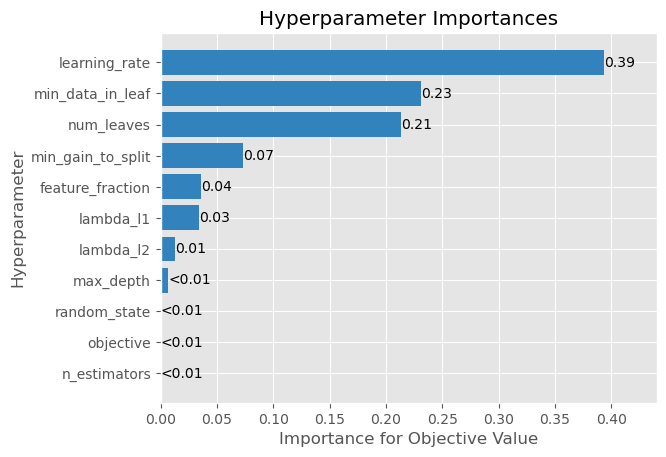

In [29]:
plot_param_importances(study)

In [30]:
best_params_ver1 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver1)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] feature_fraction is set=0.794579042015851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794579042015851
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=23.413874354113094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=23.413874354113094
[LightGBM] [Warning] lambda_l2 is set=2.3016414046803466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3016414046803466


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799213.130,1.724636e+12,1313253.847,NaN,0.742,17.193,74.737,34.202
LGBMRegressor,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711
LGBoost_Optuna,287818.645,4.129299e+11,642596.229,0.247,0.938,-4.379,16.842,12.317


In [31]:
check_overfitting(lgb_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 266400.543
mean_absolute_error test: 287818.645
delta = 8.0 %


In [32]:
study.optimize(func, n_trials=25, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8369313616319201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8369313616319201
[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=1.059694452707407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.059694452707407
[LightGBM] [Warning] lambda_l2 is set=6.142265914012317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.142265914012317
[LightGBM] [Warning] feature_fraction is set=0.8369313616319201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8369313616319201
[LightGBM] [Warning] min_data_in_leaf is set=369, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=369
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_ga

In [33]:
best_params_ver2 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver2)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna_ver2'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] feature_fraction is set=0.8602778778408093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8602778778408093
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l1 is set=4.5372480222197265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5372480222197265
[LightGBM] [Warning] lambda_l2 is set=9.539318551998749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.539318551998749


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799213.130,1.724636e+12,1313253.847,NaN,0.742,17.193,74.737,34.202
LGBMRegressor,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711
LGBoost_Optuna,287818.645,4.129299e+11,642596.229,0.247,0.938,-4.379,16.842,12.317
LGBoost_Optuna_ver2,274204.764,3.711015e+11,609180.976,0.238,0.944,-3.875,15.935,11.735


In [34]:
check_overfitting(lgb_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 235809.652
mean_absolute_error test: 274204.764
delta = 16.3 %


CatBoostRegressor

In [35]:
from catboost import Pool


cat_feat = X_train.select_dtypes('category').columns.tolist()

# целевая функция
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True), #0.07
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        #"l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),        
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        'loss_function': trial.suggest_categorical("loss_function", ['MAE']),
        "eval_metric": trial.suggest_categorical("eval_metric", ['MAE']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "allow_writing_files": trial.suggest_categorical("allow_writing_files", [False])
    }
    
    #if params["bootstrap_type"] == "Bayesian":
    #    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    #elif params["bootstrap_type"] == "Bernoulli":
    #    params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)
        
        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [36]:
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")


def func_cat(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=cat_feat)


study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
study_cat.best_params

{'n_estimators': 300,
 'learning_rate': 0.2110084185495458,
 'max_depth': 11,
 'use_best_model': True,
 'loss_function': 'MAE',
 'eval_metric': 'MAE',
 'random_state': 10,
 'allow_writing_files': False}

In [39]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='CatBoostRegressor_Optuna'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799213.130,1.724636e+12,1313253.847,NaN,0.742,17.193,74.737,34.202
LGBMRegressor,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711
LGBoost_Optuna,287818.645,4.129299e+11,642596.229,0.247,0.938,-4.379,16.842,12.317
LGBoost_Optuna_ver2,274204.764,3.711015e+11,609180.976,0.238,0.944,-3.875,15.935,11.735
CatBoostRegressor_Optuna,283940.403,3.528687e+11,594027.553,0.236,0.947,-3.052,16.225,12.151


In [40]:
check_overfitting(cat_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 233962.422
mean_absolute_error test: 283940.403
delta = 21.4 %


# Feature importance

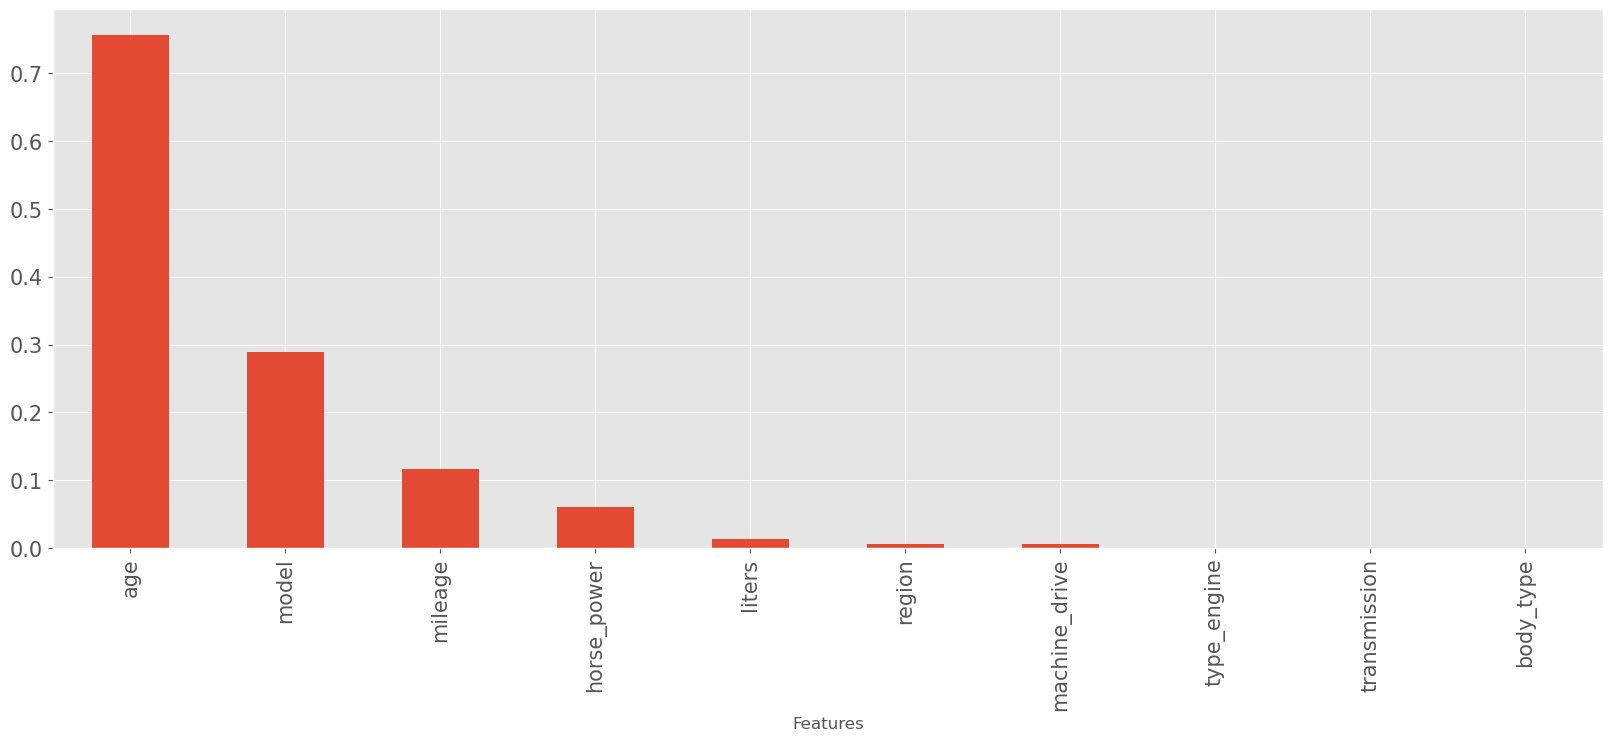

In [41]:
from sklearn.inspection import permutation_importance


r = permutation_importance(lgb_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

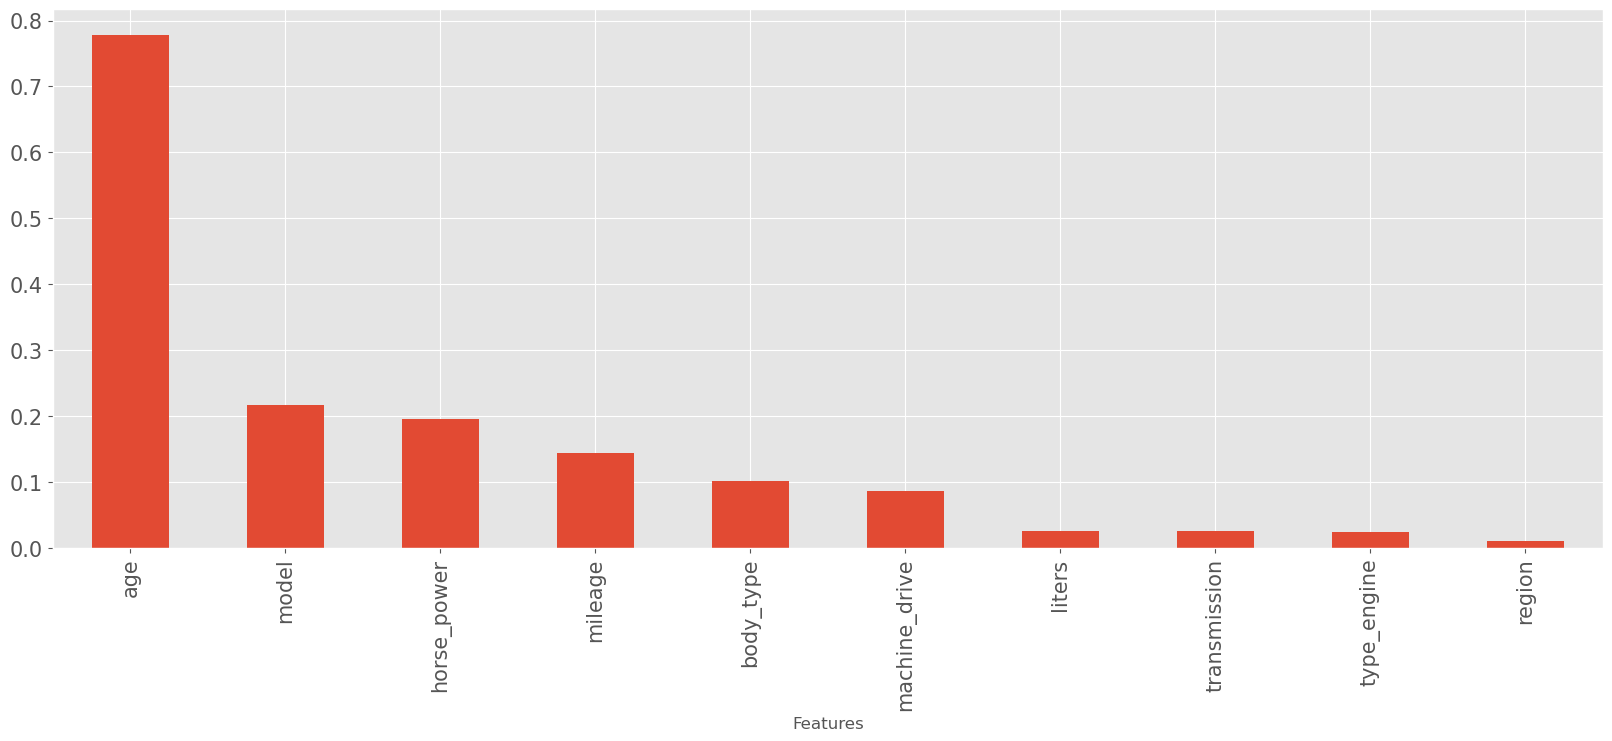

In [42]:
r = permutation_importance(cat_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()